In [1]:
# from google.colab import drive
# drive.mount('/content/drive')
# %cd '/content/drive/My Drive/Mini_DIVA'

In [2]:
from utils import *
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import importlib

In [3]:
from imputers.missforest.missforest import MissForest

 from lightgbm import LGBMClassifier

In [4]:
importlib.reload(sys.modules['utils'])

<module 'utils' from '/Users/jzhen3/Desktop/Mini_DIVA/utils.py'>

## Evaluate imputation methods

In [5]:
data, X, y, Xinds, yinds = read_dataset(dataset="insurance")

In [6]:
iscategorical(data['children'], 0.00003)

False

In [12]:
nums, cats = get_num_cat_vars(data)

In [15]:
cats

['sex', 'smoker', 'region']

In [8]:
# # for deciding what type of data scaling methods to use
# import seaborn as sns
# import matplotlib.pyplot as plt

# # Plot the distribution
# sns.distplot(data['bmi'], hist=False, rug=True)
# sns.distplot(data['age'], hist=False, rug=True)
# sns.distplot(data['children'], hist=False, rug=True)

# # Show the plot
# plt.show()

In [9]:
impute_fraction = 0.2
random_state = 42
# thres = int(len(X)*0.75)
X_miss, X_miss_idx = set_fraction_missing(
    X, fraction=impute_fraction, random_state=random_state
)

In [ ]:
impute_fraction = 0.2
random_state = 42
impute_method = 'MissForest'
error_method = "mix"
n_neighbors = 7

thres = int(len(X)*0.75)
X_miss, X_miss_idx = set_fraction_missing(
    X, fraction=impute_fraction, random_state=random_state
)
X_imp, X_le = impute(
    X_miss,
    X,
    y,
    encoding="one-hot",
    train_idx=X.index[:thres],
    test_idx=X.index[thres:],
    method=impute_method,
)
error = evaluate_imputation(
    X,
    X_imp.iloc[thres:],
    X_le.iloc[thres:],
    X_miss_idx.iloc[thres:],
    error_method=error_method,
)
print(error)

1.6763161877155413 onehot + knnimputer + uniform len(X_miss_le.columns)-1

without normalization: 2.0253048591056575
normalization = 2.0059684995078166
Label

In [ ]:
dataset = "insurance"
data, X, y, Xinds, yinds = read_dataset(dataset=dataset)

# evaluate imputation results for different imputation methods and fractions of missing values
impute_methods = ["customMICE", "KNNImputer"]  # 'zero', 'median']
impute_fractions = [0.25, 0.5, 0.75]
impute_seeds = [0, 10]  # np.arange(10)

results = {}
for impute_method in impute_methods:
    for impute_fraction in tqdm(impute_fractions):
        for impute_seed in impute_seeds:
            acc, error, X_miss, X_miss_idx, X_imp, X_le = train_impute_classifier(
                X,
                y,
                encoding="one-hot",
                impute_method=impute_method,
                error_method="mix",
                impute_fraction=impute_fraction,
                random_state=impute_seed,
            )
            for i in range(5):
                results[(impute_method, impute_fraction, impute_seed, i + 1)] = {
                    "acc": acc[i],
                    "err": error[i],
                }

  0%|          | 0/3 [00:00<?, ?it/s]

100%|██████████| 3/3 [00:08<00:00,  2.95s/it]


In [ ]:
# convert results to dataframe
df_ = {}
for i, key in enumerate(["impute_method", "impute_fraction", "impute_seed", "fold"]):
    df_[key] = [error[i] for error in results.keys()]
df_["accuracy"] = [metric["acc"] for metric in results.values()]
df_["error"] = [metric["err"] for metric in results.values()]
results_df = pd.DataFrame.from_dict(df_)

In [ ]:
# get mean and std of accuracy and rmse for each impute method and fraction
results_df = (
    results_df.groupby(["impute_method", "impute_fraction"])
    .agg({"error": ["mean", "std"], "accuracy": ["mean", "std"]})
    .reset_index()
)

# sort results by best mean rmse
results_df.sort_values(by=["impute_fraction", ("error", "mean")], inplace=True)

# print results
results_df

impute_method impute_fraction     error            accuracy          
                                     mean       std      mean       std
3    customMICE            0.25  1.474683  0.173747  1.013515  0.264646
0    KNNImputer            0.25  1.481892  0.180794  1.035673  0.265416
1    KNNImputer            0.50  1.549224  0.188328  1.250169  0.186564
4    customMICE            0.50  1.611561  0.125083  1.229539  0.191399
2    KNNImputer            0.75  1.617775  0.146730  1.382123  0.227197
5    customMICE            0.75  1.774011  0.116362  1.370923  0.259687

### Multiple fractions missing

In [ ]:
dataset = "monks"
data, X, y, Xinds, yinds = read_dataset(dataset=dataset)

# evaluate imputation results for different imputation methods and fractions of missing values
impute_methods = ["mode", "MICE"]  # , 'missForest']#['RF', 'RF_OOB', 'RF_GAP']#
impute_fractions = np.linspace(0.2, 0.6, 3)  # np.linspace(0.05, 0.45, 19)
impute_seeds = np.arange(10)
error_method = "mse"

results = {}
for impute_method in impute_methods:
    for impute_fraction in tqdm(impute_fractions):
        for impute_seed in impute_seeds:
            acc, error, X_miss, X_miss_idx, X_imp, X_le = train_impute_classifier(
                X,
                y,
                impute_method=impute_method,
                error_method=error_method,
                impute_fraction=impute_fraction,
                random_state=impute_seed,
            )

            for i in range(5):
                results[(impute_method, impute_fraction, impute_seed, i + 1)] = {
                    "acc": acc[i],
                    "err": error[i],
                }

100%|██████████| 3/3 [00:17<00:00,  5.92s/it]


In [ ]:
# convert results to dataframe
df_ = {}
for i, key in enumerate(["impute_method", "impute_fraction", "impute_seed", "fold"]):
    df_[key] = [error[i] for error in results.keys()]
df_["accuracy"] = [metric["acc"] for metric in results.values()]
df_["error"] = [metric["err"] for metric in results.values()]
results_fractions_df = pd.DataFrame.from_dict(df_)

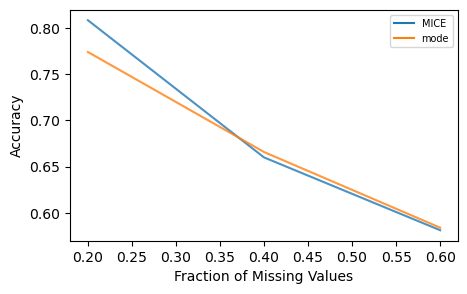

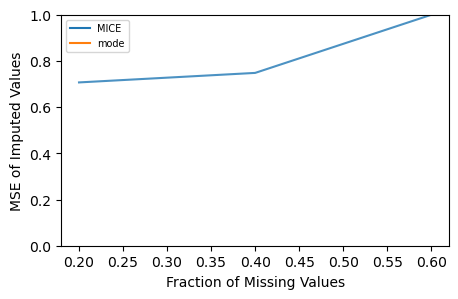

In [ ]:
# average over impute seeds
results_fractions_df = (
    results_fractions_df.groupby(["impute_method", "impute_fraction"])
    .mean()
    .reset_index()
)

# plot results
plt.figure(figsize=(5, 3))
sns.lineplot(
    x="impute_fraction",
    y="accuracy",
    hue="impute_method",
    data=results_fractions_df,
    alpha=0.8,
)
plt.ylabel("Accuracy")
plt.xlabel("Fraction of Missing Values")

# only include first 9 entries in legend
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(fontsize=7)

plt.show()

plt.figure(figsize=(5, 3))
sns.lineplot(
    x="impute_fraction",
    y="error",
    hue="impute_method",
    data=results_fractions_df,
    alpha=0.8,
)
plt.ylabel(f"{error_method.upper()} of Imputed Values")
plt.ylim(0, 1)
plt.xlabel("Fraction of Missing Values")

handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(fontsize=7)

plt.show()

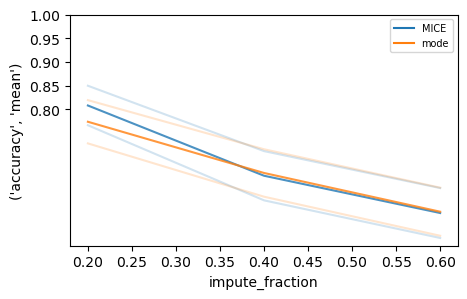

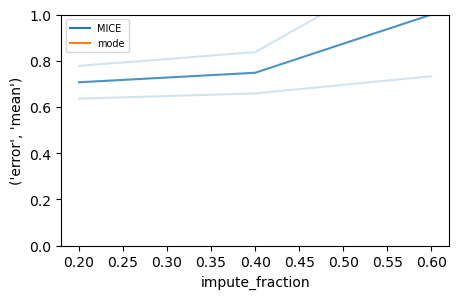

In [ ]:
# convert results to dataframe
results_fractions_df = pd.DataFrame.from_dict(df_)

# get mean and std of accuracy and rmse for each impute method and fraction
results_fractions_df = (
    results_fractions_df.groupby(["impute_method", "impute_fraction"])
    .agg({"accuracy": ["mean", "std"], "error": ["mean", "std"]})
    .reset_index()
)

# add upper and lower confidence intervals to dataframe
results_fractions_df[("accuracy", "lower_ci")] = (
    results_fractions_df[("accuracy", "mean")]
    - results_fractions_df[("accuracy", "std")]
)
results_fractions_df[("accuracy", "upper_ci")] = (
    results_fractions_df[("accuracy", "mean")]
    + results_fractions_df[("accuracy", "std")]
)
results_fractions_df.loc[
    results_fractions_df[("accuracy", "upper_ci")] > 1, ("accuracy", "upper_ci")
] = 1  # set upper confidence interval to 1 if it is greater than 1
results_fractions_df[("error", "lower_ci")] = (
    results_fractions_df[("error", "mean")] - results_fractions_df[("error", "std")]
)
results_fractions_df[("error", "upper_ci")] = (
    results_fractions_df[("error", "mean")] + results_fractions_df[("error", "std")]
)
results_fractions_df.head()

# plot mean of accuracy with std as error bars
plt.figure(figsize=(5, 3))
sns.lineplot(
    x="impute_fraction",
    y=("accuracy", "mean"),
    hue="impute_method",
    data=results_fractions_df,
    alpha=0.8,
)
sns.lineplot(
    x="impute_fraction",
    y=("accuracy", "upper_ci"),
    hue="impute_method",
    data=results_fractions_df,
    alpha=0.2,
)
sns.lineplot(
    x="impute_fraction",
    y=("accuracy", "lower_ci"),
    hue="impute_method",
    data=results_fractions_df,
    alpha=0.2,
)

# only include first 9 entries in legend
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[:2], labels[:2], fontsize=7)
plt.yticks(np.arange(0.8, 1.05, 0.05))
plt.show()

# plot mean of rmse with std as error bars
plt.figure(figsize=(5, 3))
sns.lineplot(
    x="impute_fraction",
    y=("error", "mean"),
    hue="impute_method",
    data=results_fractions_df,
    alpha=0.8,
)
sns.lineplot(
    x="impute_fraction",
    y=("error", "upper_ci"),
    hue="impute_method",
    data=results_fractions_df,
    alpha=0.2,
)
sns.lineplot(
    x="impute_fraction",
    y=("error", "lower_ci"),
    hue="impute_method",
    data=results_fractions_df,
    alpha=0.2,
)

# only include first 9 entries in legend
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[:2], labels[:2], fontsize=7)
plt.ylim(0, 1)
plt.show()

In [ ]:
handles[:2], labels[:2]

([<matplotlib.lines.Line2D at 0x7fb9b3134e50>,
 ['MICE', 'mode'])